# CellType classification model 

In [1]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Import all the required libraries

In [2]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

Load mainData and extraData into dataframes

In [3]:
mainData = pd.read_csv('./data_labels_mainData.csv')
extraData = pd.read_csv('./data_labels_extraData.csv')

mainData

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
mainData.cellTypeName.value_counts()

epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64

Check for any null values

Check if to see any null values exists

In [5]:
mainData.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

We remove the `InstanceID` column to prevent any data leaks and the `isCancerous` column since we are only predicting the cell type

In [6]:
mainData.drop(['InstanceID'], axis=1,inplace=True)
mainData.drop(['isCancerous'], axis=1,inplace=True)

In [7]:
print("#### mainData shape ####\n")
print(mainData.shape)
print("\n#### mainData info ####\n")
print(mainData.info())
print("\n#### mainData describe ####\n")
print(mainData.describe())

#### mainData shape ####

(9896, 4)

#### mainData info ####

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   patientID     9896 non-null   int64 
 1   ImageName     9896 non-null   object
 2   cellTypeName  9896 non-null   object
 3   cellType      9896 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 309.4+ KB
None

#### mainData describe ####

         patientID     cellType
count  9896.000000  9896.000000
mean     29.762025     1.501516
std      17.486553     0.954867
min       1.000000     0.000000
25%      14.000000     1.000000
50%      26.000000     2.000000
75%      47.000000     2.000000
max      60.000000     3.000000


Create a dictionary with label mapping for future predictions.

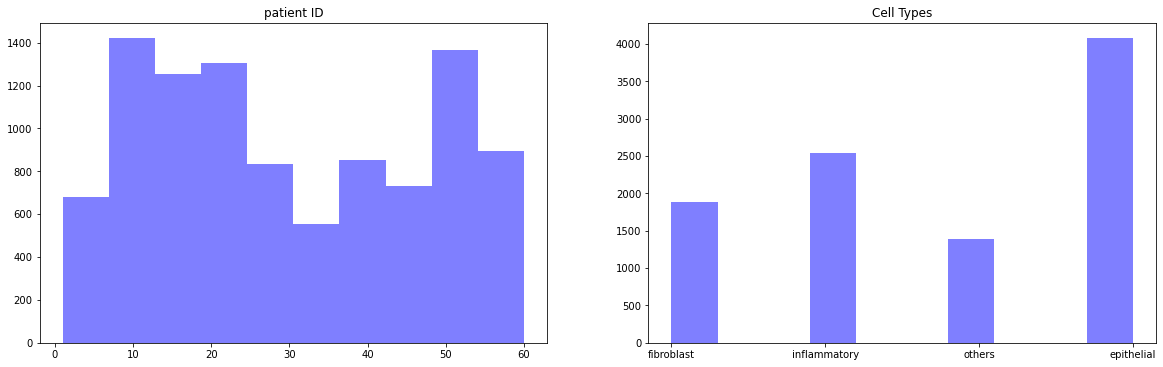

In [8]:
plt.figure(figsize=(20,20))
plt.subplot(3, 2, 1)
plt.hist(mainData['patientID'], facecolor='blue', alpha=0.5)
plt.title('patient ID')

plt.subplot(3, 2, 2)
plt.hist(mainData['cellTypeName'], facecolor='blue', alpha=0.5)
plt.title('Cell Types')
plt.show()

In [9]:
cellType_map = mainData.set_index('cellType').to_dict()['cellTypeName']

In [10]:
mainData['cellType'] = mainData['cellType'].astype('category')

## Train test validation split

While in part 1 the data was split based on the images pertaining to a patient, here we split the dataset without any processing as the goal of the model is the classify the image to a cell type, regardless of its relationship to a patient.

In [11]:
train_data, test_data = train_test_split(mainData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

In [12]:
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


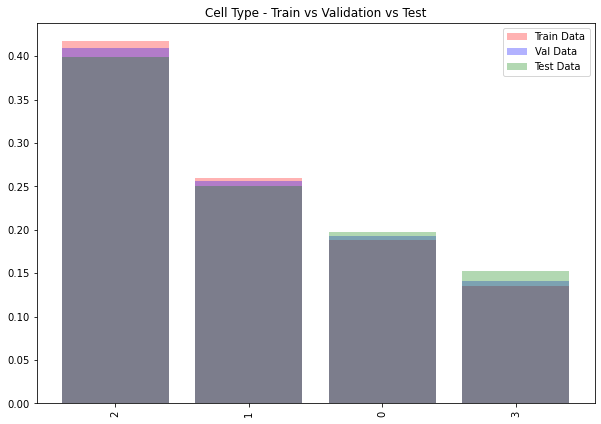

In [13]:
plt.figure(figsize=(10,7))
plt.bar(
    train_data.cellType.value_counts().index.astype(str), 
    train_data.cellType.value_counts().values/np.sum(train_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='r',
    label='Train Data'
)
plt.bar(
    val_data.cellType.value_counts().index.astype(str), 
    val_data.cellType.value_counts().values/np.sum(val_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='b',
    label='Val Data'
)
plt.bar(
    test_data.cellType.value_counts().index.astype(str), 
    test_data.cellType.value_counts().values/np.sum(test_data.cellType.value_counts().values), 
    alpha=0.3, 
    color='g',
    label='Test Data'
)

plt.title('Cell Type - Train vs Validation vs Test')
plt.xticks(rotation='vertical')
plt.legend()

## One hot encoding the labels

In [14]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(df, col, col_names = None):
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    ohe.fit(df[[col]])
    
    ohe_ = ohe.transform(df[[col]]).toarray()
    
    if (col_names == None):
        col_names = ohe.categories_[0]
        
        for i in range(len(ohe.categories_[0])):
            df[col + '_' + str(col_names[i])] = ohe_[:,i]
            
        df.drop(col, axis = 1, inplace = True)

In [15]:
one_hot_encode(train_data, 'cellType')
one_hot_encode(val_data, 'cellType')
one_hot_encode(test_data, 'cellType')

<ipython-input-14-ba2fe6a3a20f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_' + str(col_names[i])] = ohe_[:,i]
/home/magnuscake/miniconda3/envs/tf_cpu/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Image preprocessing

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale is done here to normalize the pixels in a range of 0-1
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

# This the default batch size
batch_size = 32
columns = ['cellType_0', 'cellType_1', 'cellType_2', 'cellType_3']

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

Found 5937 validated image filenames.
Found 1979 validated image filenames.
Found 1980 validated image filenames.


# Utility Functions

## Plot functions

In [17]:
# Learning curve diagnostic tool
def plot_fit_history(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [18]:
# def plot_confusion_matrix(test, pred):
#     cm = confusion_matrix(test, pred)
#     group_names = ['True Neg','False Pos','False Neg','True Pos']
#     group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
#     group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
#     labels = np.asarray(labels).reshape(2,2)
#     sns.heatmap(cm, annot=True, fmt='', cmap='Blues')

def plot_confusion_matrix(test, pred, title='Confusion matrix', cmap=None, normalize=True):
    
    import itertools
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(test, pred)
    target_names = [0, 1, 2, 3]
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Model development functions

In [19]:
def compile_model(model):
    sgd = tf.keras.optimizers.SGD(learning_rate=0.01)
#     opt = tf.keras.optimizers.Adagrad()
    
    model.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', 'accuracy'])

In [20]:
early_stopping_monitor = EarlyStopping(patience=10, monitor='val_categorical_accuracy')

def fit_model(model, train_gen=train_generator, val_gen=validation_generator):

    print('start ', datetime.datetime.now().strftime("%H:%M:%S"))
    now = datetime.datetime.now()

    fit_history = model.fit(train_generator, validation_data = validation_generator, 
                            callbacks=[early_stopping_monitor], epochs=10000, verbose=1)

    print('stop ', datetime.datetime.now().strftime("%H:%M:%S"))
    print("Took = ", datetime.datetime.now() - now)
    
    return fit_history

In [21]:
def predict_model(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

In [22]:
class ModelResult:
  def __init__(self, name, accuracy, f1, precision, recall):
    self.name = name
    self.accuracy = accuracy
    self.f1 = f1
    self.precision = precision
    self.recall = recall
    
modelResults = list()

def show_stats(test_name, y_test, y_pred):
    accuracy = accuracy_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y, average='macro')
    cm = classification_report(test_y, pred_y, zero_division=0)
    
    prfs = precision_recall_fscore_support(test_y, pred_y, zero_division=0)
    detect_precision = prfs[0][1]
    detect_recall = prfs[1][1]

    mr = ModelResult(test_name, accuracy, f1, detect_precision, detect_recall)
    modelResults.append(mr)

    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("F1 score: ", f1_score(test_y, pred_y, average='macro'))
    print(classification_report(test_y, pred_y, zero_division=0))

# Baseline model

- Initial baseline NN model
- 4 output classes, with OneHotEncoding
- Input has 2187 dims (this is small for image recognition)
- 1 hidden layer with 256 internal nodes
- Loss - Categorical Cross Entropy
- Metric - categorical_accuracy

In [23]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4 # Flag for output layer

base_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES)
])

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


Initial the optimizer to use with the learning rate.

In [25]:
compile_model(base_model)

In [26]:
base_history = fit_model(base_model)

start  19:34:27
Epoch 1/10000
186/186 [==============================] - 3s 12ms/step - loss: 1.2462 - categorical_accuracy: 0.4664 - accuracy: 0.4664 - val_loss: 1.0979 - val_categorical_accuracy: 0.5836 - val_accuracy: 0.5836
Epoch 2/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.0628 - categorical_accuracy: 0.5604 - accuracy: 0.5604 - val_loss: 1.0929 - val_categorical_accuracy: 0.5609 - val_accuracy: 0.5609
Epoch 3/10000
186/186 [==============================] - 2s 12ms/step - loss: 0.9899 - categorical_accuracy: 0.5961 - accuracy: 0.5961 - val_loss: 0.9335 - val_categorical_accuracy: 0.6150 - val_accuracy: 0.6150
Epoch 4/10000
186/186 [==============================] - 2s 12ms/step - loss: 0.9520 - categorical_accuracy: 0.6160 - accuracy: 0.6160 - val_loss: 0.9238 - val_categorical_accuracy: 0.6175 - val_accuracy: 0.6175
Epoch 5/10000
186/186 [==============================] - 2s 12ms/step - loss: 0.9038 - categorical_accuracy: 0.6444 - accuracy: 0.6444 -

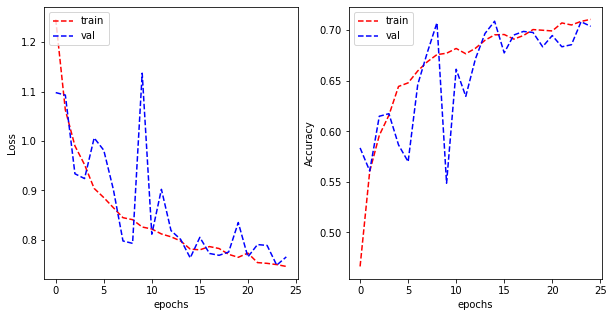

In [27]:
plot_fit_history(base_history.history['loss'], base_history.history['val_loss'],
                    base_history.history['categorical_accuracy'], base_history.history['val_categorical_accuracy'])

In [28]:
(test_y, pred_y) = predict_model(base_model)

In [29]:
show_stats('Baseline', test_y, pred_y)

Accuracy score:  0.6935290024669492
F1 score:  0.5804058705168477
              precision    recall  f1-score   support

           0       0.69      0.52      0.59     12488
           1       0.57      0.86      0.68     15841
           2       0.81      0.90      0.85     25261
           3       0.59      0.12      0.19      9646

    accuracy                           0.69     63236
   macro avg       0.67      0.60      0.58     63236
weighted avg       0.69      0.69      0.66     63236



Model seems to be doing alright. Trying some regularization to see if the performance can be improved

In [30]:
reg_lambda = 0.001

reg_model = keras.Sequential([
    keras.layers.Flatten(input_shape=INPUT_DIM),
    keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu')
])

In [31]:
compile_model(reg_model)

In [32]:
reg_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [33]:
reg_history = fit_model(reg_model)

start  19:36:37
Epoch 1/10000
186/186 [==============================] - 3s 13ms/step - loss: 1.8441 - categorical_accuracy: 0.1937 - accuracy: 0.1937 - val_loss: 1.8414 - val_categorical_accuracy: 0.1930 - val_accuracy: 0.1930
Epoch 2/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.8397 - categorical_accuracy: 0.1878 - accuracy: 0.1878 - val_loss: 1.8380 - val_categorical_accuracy: 0.1930 - val_accuracy: 0.1930
Epoch 3/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.8363 - categorical_accuracy: 0.1878 - accuracy: 0.1878 - val_loss: 1.8346 - val_categorical_accuracy: 0.1930 - val_accuracy: 0.1930
Epoch 4/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.8330 - categorical_accuracy: 0.1878 - accuracy: 0.1878 - val_loss: 1.8313 - val_categorical_accuracy: 0.1930 - val_accuracy: 0.1930
Epoch 5/10000
186/186 [==============================] - 2s 12ms/step - loss: 1.8297 - categorical_accuracy: 0.1878 - accuracy: 0.1878 -

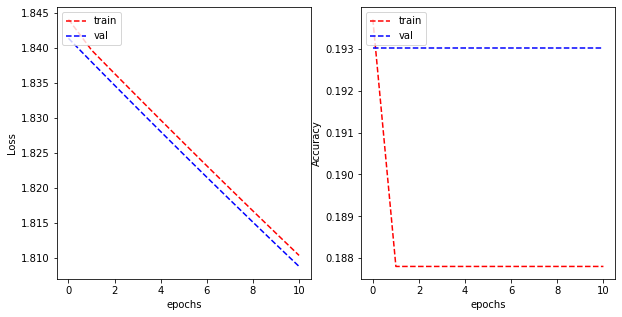

In [34]:
plot_fit_history(reg_history.history['loss'], reg_history.history['val_loss'],
                    reg_history.history['categorical_accuracy'], reg_history.history['val_categorical_accuracy'])

In [35]:
(test_y, pred_y) = predict_model(reg_model)

In [36]:
show_stats('Baseline Reg', test_y, pred_y)

Accuracy score:  0.19749493927125505
F1 score:  0.08246170100369783
              precision    recall  f1-score   support

           0       0.20      1.00      0.33     12488
           1       0.00      0.00      0.00     15836
           2       0.00      0.00      0.00     25260
           3       0.00      0.00      0.00      9648

    accuracy                           0.20     63232
   macro avg       0.05      0.25      0.08     63232
weighted avg       0.04      0.20      0.07     63232



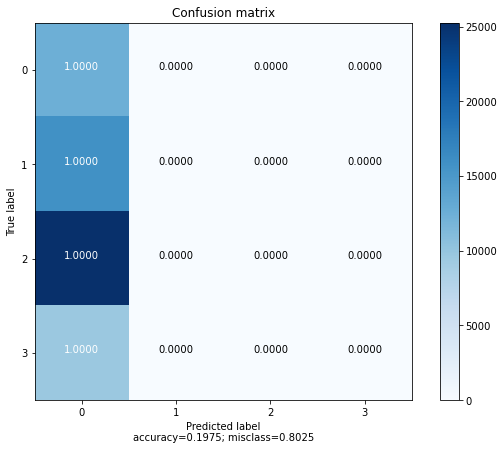

In [37]:
plot_confusion_matrix(test_y, pred_y)

We can clearly see from the above that performance was horrible. The baseline model won't be enough in the long run, even with regularization. Therefore, we explore other more complicated models

## Base VGG model

In [38]:
VGG_model = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
#     keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
#     keras.layers.Dense(OUTPUT_CLASSES, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda))
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu')
])

In [39]:
compile_model(VGG_model)

In [40]:
VGG_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)        

In [41]:
VGG_history = fit_model(VGG_model)

start  19:38:22
Epoch 1/10000
186/186 [==============================] - 15s 80ms/step - loss: 1.3863 - categorical_accuracy: 0.1881 - accuracy: 0.1881 - val_loss: 1.3863 - val_categorical_accuracy: 0.1935 - val_accuracy: 0.1935
Epoch 2/10000
186/186 [==============================] - 15s 81ms/step - loss: 1.3863 - categorical_accuracy: 0.1932 - accuracy: 0.1932 - val_loss: 1.3863 - val_categorical_accuracy: 0.2021 - val_accuracy: 0.2021
Epoch 3/10000
186/186 [==============================] - 17s 90ms/step - loss: 1.3857 - categorical_accuracy: 0.2361 - accuracy: 0.2361 - val_loss: 1.3844 - val_categorical_accuracy: 0.2567 - val_accuracy: 0.2567
Epoch 4/10000
186/186 [==============================] - 17s 89ms/step - loss: 1.3586 - categorical_accuracy: 0.3360 - accuracy: 0.3360 - val_loss: 1.3098 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 5/10000
186/186 [==============================] - 16s 88ms/step - loss: 1.2922 - categorical_accuracy: 0.4196 - accuracy: 0.4

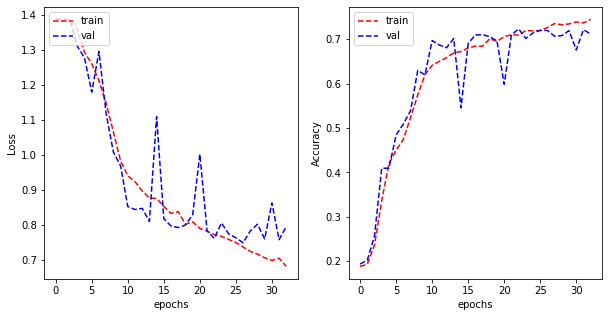

In [42]:
plot_fit_history(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

 Model seems to be overfitting. There are a couple of things we can do here. We have gone with removing 1 VGG block as well as add a dropout layer

In [43]:
(test_y, pred_y) = predict_model(VGG_model)

In [44]:
show_stats('VGG', test_y, pred_y)

Accuracy score:  0.6978744939271255
F1 score:  0.5407023103719888
              precision    recall  f1-score   support

           0       0.66      0.54      0.60     12483
           1       0.60      0.89      0.71     15842
           2       0.79      0.92      0.85     25257
           3       0.00      0.00      0.00      9650

    accuracy                           0.70     63232
   macro avg       0.51      0.59      0.54     63232
weighted avg       0.60      0.70      0.64     63232



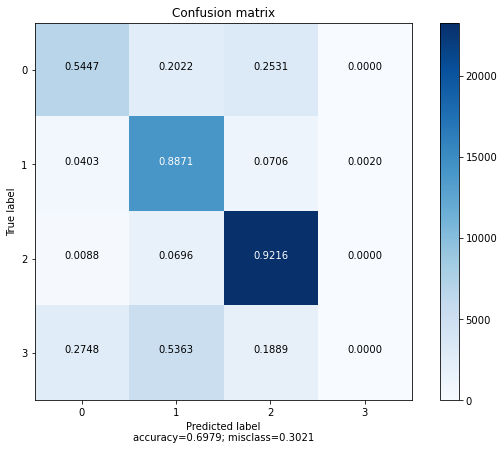

In [45]:
plot_confusion_matrix(test_y, pred_y)

# VGG 2 model with Dropout

In [46]:
VGG2_model = keras.Sequential([
    #VGG block 1
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(reg_lambda)),
    keras.layers.Dropout(.2),
    keras.layers.Dense(OUTPUT_CLASSES, activation='relu')
])

In [47]:
compile_model(VGG2_model)

In [48]:
VGG2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

In [49]:
VGG2_history = fit_model(VGG2_model)

start  19:49:19
Epoch 1/10000
186/186 [==============================] - 12s 65ms/step - loss: 1.5591 - categorical_accuracy: 0.4090 - accuracy: 0.4090 - val_loss: 1.5147 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 13s 69ms/step - loss: 1.4851 - categorical_accuracy: 0.4553 - accuracy: 0.4553 - val_loss: 1.3999 - val_categorical_accuracy: 0.5316 - val_accuracy: 0.5316
Epoch 3/10000
186/186 [==============================] - 14s 74ms/step - loss: 1.4031 - categorical_accuracy: 0.5129 - accuracy: 0.5129 - val_loss: 1.4397 - val_categorical_accuracy: 0.4841 - val_accuracy: 0.4841
Epoch 4/10000
186/186 [==============================] - 13s 71ms/step - loss: 1.3031 - categorical_accuracy: 0.5744 - accuracy: 0.5744 - val_loss: 1.1978 - val_categorical_accuracy: 0.6473 - val_accuracy: 0.6473
Epoch 5/10000
186/186 [==============================] - 13s 71ms/step - loss: 1.2212 - categorical_accuracy: 0.6200 - accuracy: 0.6

186/186 [==============================] - 13s 70ms/step - loss: 0.6893 - categorical_accuracy: 0.8070 - accuracy: 0.8070 - val_loss: 0.8657 - val_categorical_accuracy: 0.7479 - val_accuracy: 0.7479
Epoch 40/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.6840 - categorical_accuracy: 0.8082 - accuracy: 0.8082 - val_loss: 0.8988 - val_categorical_accuracy: 0.7367 - val_accuracy: 0.7367
Epoch 41/10000
186/186 [==============================] - 14s 73ms/step - loss: 0.6629 - categorical_accuracy: 0.8228 - accuracy: 0.8228 - val_loss: 0.8711 - val_categorical_accuracy: 0.7383 - val_accuracy: 0.7383
Epoch 42/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.6509 - categorical_accuracy: 0.8260 - accuracy: 0.8260 - val_loss: 0.8971 - val_categorical_accuracy: 0.7367 - val_accuracy: 0.7367
Epoch 43/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.6308 - categorical_accuracy: 0.8282 - accuracy: 0.8282 - val_loss: 0.9521 - v

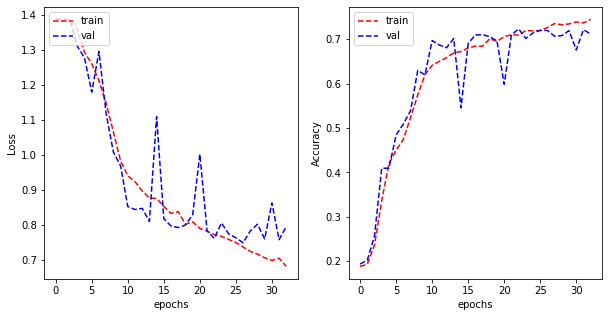

In [50]:
plot_fit_history(VGG_history.history['loss'], VGG_history.history['val_loss'],
                    VGG_history.history['categorical_accuracy'], VGG_history.history['val_categorical_accuracy'])

Performance seems slightly better, but definately can be imporved upon. As of right now, overfitting seems to be the main problem.

In [51]:
(test_y, pred_y) = predict_model(VGG_model)

In [52]:
show_stats('VGG 2', test_y, pred_y)

Accuracy score:  0.6981275303643725
F1 score:  0.5408538830465599
              precision    recall  f1-score   support

           0       0.66      0.54      0.60     12487
           1       0.60      0.89      0.71     15833
           2       0.79      0.92      0.85     25269
           3       0.00      0.00      0.00      9643

    accuracy                           0.70     63232
   macro avg       0.51      0.59      0.54     63232
weighted avg       0.60      0.70      0.64     63232



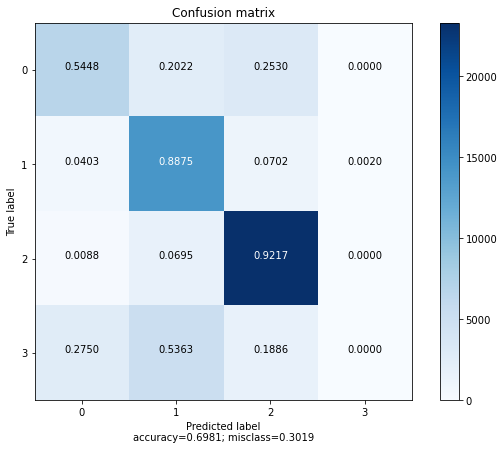

In [53]:
plot_confusion_matrix(test_y, pred_y)

There is almost no difference between the two models. There overfitting issue still seems to persist, despite regularization and dropout. Therefore, we will running the model with data augumentation

## VGG with Data Augumentation

In [54]:
aug_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=90, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
aug_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32
columns = ['cellType_0', 'cellType_1', 'cellType_2', 'cellType_3']

aug_train_generator = aug_train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle=False
)

aug_validation_generator = aug_val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory = './patch_images',
    x_col = 'ImageName',
    y_col = columns,
    target_size = (27, 27),
    batch_size = batch_size,
    class_mode = 'raw',
    shuffle = False
)

Found 5937 validated image filenames.
Found 1979 validated image filenames.


In [55]:
compile_model(VGG2_model)

In [56]:
VGG2_aug = fit_model(VGG2_model, aug_train_generator, aug_validation_generator)

start  20:01:07
Epoch 1/10000
186/186 [==============================] - 12s 64ms/step - loss: 0.6055 - categorical_accuracy: 0.8413 - accuracy: 0.8413 - val_loss: 0.9071 - val_categorical_accuracy: 0.7271 - val_accuracy: 0.7271
Epoch 2/10000
186/186 [==============================] - 13s 69ms/step - loss: 0.5982 - categorical_accuracy: 0.8461 - accuracy: 0.8461 - val_loss: 0.9103 - val_categorical_accuracy: 0.7337 - val_accuracy: 0.7337
Epoch 3/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.5712 - categorical_accuracy: 0.8565 - accuracy: 0.8565 - val_loss: 0.9080 - val_categorical_accuracy: 0.7347 - val_accuracy: 0.7347
Epoch 4/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.5563 - categorical_accuracy: 0.8637 - accuracy: 0.8637 - val_loss: 0.9585 - val_categorical_accuracy: 0.7211 - val_accuracy: 0.7211
Epoch 5/10000
186/186 [==============================] - 13s 70ms/step - loss: 0.5595 - categorical_accuracy: 0.8604 - accuracy: 0.8

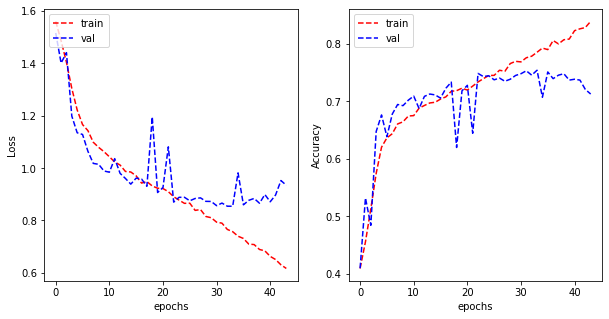

In [57]:
plot_fit_history(VGG2_history.history['loss'], VGG2_history.history['val_loss'],
                    VGG2_history.history['categorical_accuracy'], VGG2_history.history['val_categorical_accuracy'])

In [59]:
(test_y, pred_y) = predict_model(VGG2_model)

In [60]:
show_stats('VGG 2 Aug', test_y, pred_y)

Accuracy score:  0.7233362854251012
F1 score:  0.6430470952103307
              precision    recall  f1-score   support

           0       0.64      0.66      0.65     12487
           1       0.69      0.75      0.72     15835
           2       0.84      0.91      0.87     25265
           3       0.46      0.26      0.33      9645

    accuracy                           0.72     63232
   macro avg       0.66      0.65      0.64     63232
weighted avg       0.70      0.72      0.71     63232



- There is certainly an improvement in the overall accuracy
- However the loss and accuracy fluctuates a lot more, despite having a constant learning rate

# SC-CNN (Spatially Constrained CNN)

Here we make an attempt at applying the SC-CNN that was used in the linked paper, and which also gave a good performance in part 1

In [61]:
SCCNN_model = tf.keras.Sequential([
    # Convolution
    tf.keras.layers.Conv2D(24, (4, 4), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='softmax'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='relu')
    
])

In [62]:
compile_model(SCCNN_model)

In [63]:
SCCNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 27, 27, 24)        1176      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 36)        7812      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 36)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               664064    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [64]:
SCCNN_history = fit_model(SCCNN_model)

start  20:50:19
Epoch 1/10000
186/186 [==============================] - 4s 22ms/step - loss: 1.3655 - categorical_accuracy: 0.4174 - accuracy: 0.4174 - val_loss: 1.3513 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 2/10000
186/186 [==============================] - 4s 21ms/step - loss: 1.3397 - categorical_accuracy: 0.4174 - accuracy: 0.4174 - val_loss: 1.3358 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 3/10000
186/186 [==============================] - 4s 21ms/step - loss: 1.3281 - categorical_accuracy: 0.4174 - accuracy: 0.4174 - val_loss: 1.3294 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 4/10000
186/186 [==============================] - 4s 21ms/step - loss: 1.3231 - categorical_accuracy: 0.4174 - accuracy: 0.4174 - val_loss: 1.3268 - val_categorical_accuracy: 0.4093 - val_accuracy: 0.4093
Epoch 5/10000
186/186 [==============================] - 4s 21ms/step - loss: 1.3210 - categorical_accuracy: 0.4174 - accuracy: 0.4174 -

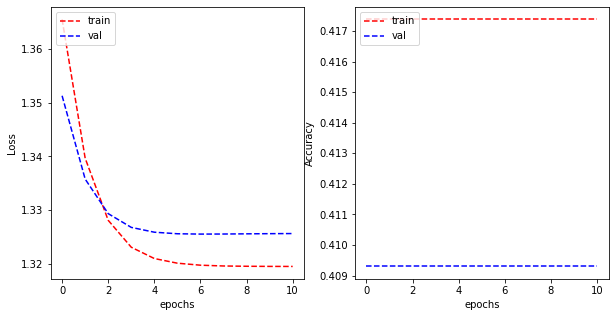

In [65]:
plot_fit_history(SCCNN_history.history['loss'], SCCNN_history.history['val_loss'],
                    SCCNN_history.history['categorical_accuracy'], SCCNN_history.history['val_categorical_accuracy'])

In [66]:
(test_y, pred_y) = predict_model(SCCNN_model)

In [67]:
show_stats('SC-CNN', test_y, pred_y)

Accuracy score:  0.3995287196356275
F1 score:  0.14273687778970562
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     12481
           1       0.00      0.00      0.00     15849
           2       0.40      1.00      0.57     25263
           3       0.00      0.00      0.00      9639

    accuracy                           0.40     63232
   macro avg       0.10      0.25      0.14     63232
weighted avg       0.16      0.40      0.23     63232



# Model comparison and ultimate judgment

In [68]:
#Print out Summary Results
print("{:20} {:>10} {:>10} {:>10} {:>10}".format('Name', 'Accuracy', 'F1-score', 'Precision', 'Recall'))
for mr in modelResults:
    print("{:20} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(mr.name, mr.accuracy, mr.f1, mr.precision, mr.recall))

Name                   Accuracy   F1-score  Precision     Recall
Baseline                   0.69       0.58       0.57       0.86
Baseline Reg               0.20       0.08       0.00       0.00
VGG                        0.70       0.54       0.60       0.89
VGG 2                      0.70       0.54       0.60       0.89
VGG 2 Aug                  0.72       0.64       0.69       0.75
SC-CNN                     0.40       0.14       0.00       0.00


- All the models that we have developed so far had issues with the loss and accuracy fluctuations
- The baseline model already seemed to do pretty well without the need for more layers